## downloading, reading csv files & preprocessing df

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### reading data & attribute selection
The focus point is about taxi fare rate:dpm (dollar per mile) and its related/influenced factors. A guess of possible related attributes in the raw data are: trip_distance, money-attributes(RatecodeID, fare_amount, tip_amount, total_amount), datetime-attributes(tpep_pickup_datetime, tpep_dropoff_datetime) and PULocationID.

Leaving passenger_count, store_and_fwd_flag, improvement_surcharge, extra, mta_tax, tolls_amount, congestion_surcharge, VendorID, payment_type and DOLocationID not selected.

The first 3 attributes are very obviously less related to dpm, so directly avoid reading them in to save memory.

1.passenger_count: According to "Tax Fare", 'There is no charge for extra passengers', so passenger_count won't have influence on any money-attributes.

2.store_and_fwd_flag: a categorical attribute about way of trip record, no useful information about our focus.

3.improvement_surcharge: According to "Taxi Fare", improvement_surcharge is charged on every kind of trip without any condition, and as theoretically total_amount equal to the sum of all other money-attributes, the improvement_surcharge can be easily combined into the constant parameter in linear regression.

In [66]:
from os.path import getsize
from urllib.request import urlretrieve

output_dir = "../raw_data"
fname_template = "yellow_tripdata_2019"

for m in [1,2,3,10,11,12]:
    month = str(m).zfill(2)
    out = f'{fname_template}-{month}.csv'
    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/{out}"
    urlretrieve(url, f"{output_dir}/{out}")

    print(f"Done downloading {out} to {output_dir} with size {getsize(f'{output_dir}/{out}') / 1073741824:.2f}GB")

Done downloading yellow_tripdata_2019-01.csv to ../raw_data with size 0.64GB


In [2]:
col_selected = ['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance','PULocationID','DOLocationID',
                'RatecodeID','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','total_amount',
                'congestion_surcharge']
col_dtypes = {'VendorId':np.float64,'tpep_pickup_datetime':'object','tpep_dropoff_datetime':'object',
              'trip_distance':np.float64,'PULocationID':np.int32,'DOLocationID':np.int32,'RatecodeID':np.float64,
              'payment_type':np.float64,'fare_amount':np.float64,'extra':np.float64,'mta_tax':np.float64,
              'tip_amount':np.float64,'tolls_amount':np.float64,'total_amount':np.float64,'congestion_surcharge':np.float64}
col_na = {'PULocationID':'', 'DOLocationID':''}
df = pd.read_csv("../raw_data/yellow_tripdata_2019-01.csv", usecols=col_selected, dtype=col_dtypes)
for mstr in ['02','03','10','11','12']:
    df_new = pd.read_csv("../raw_data/yellow_tripdata_2019-"+mstr+".csv", usecols=col_selected, dtype=col_dtypes)
    df = df.append(df_new, ignore_index=True)

In [3]:
df.shape

(43508031, 14)

In [3]:
# remove rows containing NaN
df = df.dropna()
df.shape

(38506819, 15)

In [4]:
# convert datetime string objects into datetime datatype
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [5]:
print(df.dtypes)
df.tail()

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
congestion_surcharge            float64
dtype: object


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge
43457008,2.0,2019-12-31 23:09:42,2019-12-31 23:22:39,1.47,1.0,68,246,2.0,10.0,0.5,0.5,0.00,0.0,13.80,2.5
43457009,2.0,2019-12-31 23:46:57,2019-12-31 23:50:54,0.97,1.0,233,170,1.0,5.0,0.5,0.5,1.76,0.0,10.56,2.5
43457010,2.0,2019-12-31 23:22:03,2019-12-31 23:29:06,3.30,1.0,262,224,1.0,11.0,0.5,0.5,2.96,0.0,17.76,2.5
43457011,2.0,2019-12-31 23:33:47,2019-12-31 23:40:10,1.55,1.0,137,4,2.0,7.0,0.5,0.5,0.00,0.0,10.80,2.5
43457012,2.0,2019-12-31 23:55:19,2020-01-01 00:03:20,1.51,1.0,229,237,2.0,7.5,0.5,0.5,0.00,0.0,11.30,2.5


In [7]:
# correlation of dpm against total_amount, fare_amount, tip_amount, extra, mta_tax, tolls_amount, congestion_surcharge
df.loc[df['trip_distance']>0][['total_amount', 'fare_amount', 'tip_amount', 'extra', 'mta_tax', 'tolls_amount', 'congestion_surcharge']].corrwith(df.loc[df['trip_distance']>0]['total_amount']/df.loc[df['trip_distance']>0]['trip_distance'])

total_amount            0.108634
fare_amount             0.108076
tip_amount              0.031781
extra                  -0.003300
mta_tax                 0.008847
tolls_amount            0.004857
congestion_surcharge   -0.004290
dtype: float64

In [8]:
# eliminate the rest 5 attributes discussed above
df = df.drop(columns=['extra','mta_tax','tolls_amount','congestion_surcharge'])

Although VendorID, payment_type and DOLocationID will not be selected for the final attributes in use, they will still be used in row elimination process to remove instances with invalid/unwanted values of these attributes.

### row elimination

In [9]:
df.describe()

,VendorID,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount
count,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07,3.850682e+07
mean,1.648052e+00,2.928816e+00,1.062819e+00,1.636933e+02,1.618286e+02,1.281697e+00,1.315997e+01,2.216832e+00,1.897351e+01
std,4.940170e-01,4.928323e+00,7.781968e-01,6.585201e+01,7.008215e+01,4.757621e-01,2.095397e+02,2.296971e+01,2.268097e+02
min,1.000000e+00,-2.301000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-2.008000e+02,-1.472800e+03
25%,1.000000e+00,9.600000e-01,1.000000e+00,1.250000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,1.116000e+01
50%,2.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,1.860000e+00,1.469000e+01
75%,2.000000e+00,2.990000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.450000e+01,2.950000e+00,2.038000e+01
max,4.000000e+00,1.913018e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,9.432748e+05,1.414920e+05,1.084772e+06


Looking at min, max, it's obvious that exept for payment_type, all other attributes have invalid data.

Based on the result table, going attribute by attribute to eliminate instances with invalid attribute values, still need to check datetime attributes(), although they are not shown in the table

The following code keeps record of number of invalid instances and number of instances left in dataframe everytime an elimination is performed. This is just a reference for checking correct elimination.

In [10]:
# check whether all datetime objects are in 2019
print(df['tpep_pickup_datetime'].dt.year.unique(), df['tpep_dropoff_datetime'].dt.year.unique())
print(df.loc[(df['tpep_pickup_datetime'].dt.year != 2019) | (df['tpep_dropoff_datetime'].dt.year != 2019)].shape)

# check whether all pickup_datetime are before dropoff_datetime
print(df.loc[df['tpep_pickup_datetime'] >= df['tpep_dropoff_datetime']].shape)
# also trip_distance are mostly 0 where pickup_datetime is after dropoff_datetime, so these rows probably won't be very useful
print(df.loc[(df['tpep_pickup_datetime'] >= df['tpep_dropoff_datetime']) & (df['trip_distance'] == 0)].shape)

[2019 2009 2008 2038 2002 2041 2020 2003 2015 2029 2090 2058 2026 2066] [2019 2009 2008 2018 2038 2003 2041 2020 2015 2029 2090 2058 2026 2066]
(1779, 11)
(29489, 11)
(27142, 11)


In [11]:
# keep instances with valid year and datetime
df = df.loc[(df['tpep_pickup_datetime'].dt.year == 2019) & (df['tpep_dropoff_datetime'].dt.year == 2019)]
df = df.loc[df['tpep_pickup_datetime'] < df['tpep_dropoff_datetime']]
print(df.shape) # there's overlap between the two elimination conditions, so shape might not seem consistence

(38475554, 11)


In [12]:
# invalid VendorID values
print(df['VendorID'].unique(), df.loc[~(df['VendorID'].isin([1,2]))].shape)

# remove VendorID==4 instances
df = df.loc[df['VendorID'].isin([1,2])]
print(df.shape, df['VendorID'].unique())

[1. 2. 4.] (102501, 11)
(38373053, 11) [1. 2.]


In [13]:
# invalid trip_distance
print(df.loc[df['trip_distance'] <= 0].shape)

# keep instances where trip_distance > 0
df = df.loc[df['trip_distance'] > 0]
print(df.shape)

(300791, 11)
(38072262, 11)


In [14]:
# invalid RatecodeID
print(df['RatecodeID'].unique(), df.loc[df['RatecodeID'] > 6].shape)

# keep instances where RatecodeID is one of [1,2,3,4,5,6]
df = df.loc[df['RatecodeID'].isin([1,2,3,4,5,6])]
print(df.shape)

[ 1.  2.  5.  4.  3. 99.  6.] (896, 11)
(38071366, 11)


In [15]:
# invalid PULocationID and DOLocationID
print(df.loc[(df['PULocationID'] > 263) | (df['DOLocationID'] > 263)].shape)

# keep valid instances (PULocationID and DOLocationID are integers from 1 to 263)
df = df.loc[(df['PULocationID'] <= 263) & (df['DOLocationID'] <= 263)]
print(df.shape)

(422029, 11)
(37649337, 11)


In [16]:
# no invalid payment_type, but only keep instances with payment_type=1 or 2
df = df.loc[df['payment_type'] <= 2]
print(df.shape)

(37409589, 11)


All 3 money attributtes have negative values. First operate a simple filter: both fare_amount and total_amount >= 2.5. According to Taxi Fare Rate, all fare_amount and total_amount should be >= 2.5 as there's an initial charge applied once trip starts.

In [17]:
# invalid total_amount and fare_amount
print(df.loc[(df['total_amount'] < 2.5) | (df['fare_amount'] < 2.5)].shape)

# keep instances with valid fare_amount and total_amount
df = df.loc[(df['total_amount'] >= 2.5) & (df['fare_amount'] >= 2.5)]
print(df.shape)
print(df.loc[df['tip_amount'] < 0].shape) # there's no negative tip_amount after filtering on fare_amount and total_amount

(14929, 11)
(37394660, 11)
(0, 11)


Create and add another filter for the dataframe: the taxi fare rate in dollar per mile: dpm. According to "Taxi Fare", it should be >= 2.5 dollar/mile

In [18]:
# create the dpm attribute, and add it into the dataframe
dpm = df['total_amount']/df['trip_distance']
print(dpm.describe())
df.insert(0, 'dpm', dpm)

# invalid fare rate (dpm < 2.5)
print(dpm.loc[dpm < 2.5].shape)

# keep valid instances where dpm >= 2.5
df = df.loc[dpm >= 2.5]
print(df.shape)

count    3.739466e+07
mean     1.169745e+01
std      8.557853e+01
min      5.750077e-04
25%      6.273764e+00
50%      8.710526e+00
75%      1.196721e+01
max      4.153000e+04
dtype: float64
(13056,)
(37381604, 12)


In [19]:
# remove VendorID, payment_type and DOLocationID attributes
df = df.drop(columns=['VendorID', 'payment_type', 'DOLocationID'])
print(df.shape)

(37381604, 9)


In [20]:
df.columns

Index(['dpm', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'RatecodeID', 'PULocationID', 'fare_amount', 'tip_amount',
       'total_amount'],
      dtype='object')

### dpm (taxi fare rate in dollar per mile) & outlier

In [22]:
df['dpm'].describe()

count    3.738160e+07
mean     1.170084e+01
std      8.559328e+01
min      2.500000e+00
25%      6.276923e+00
50%      8.712329e+00
75%      1.197183e+01
max      4.153000e+04
dtype: float64


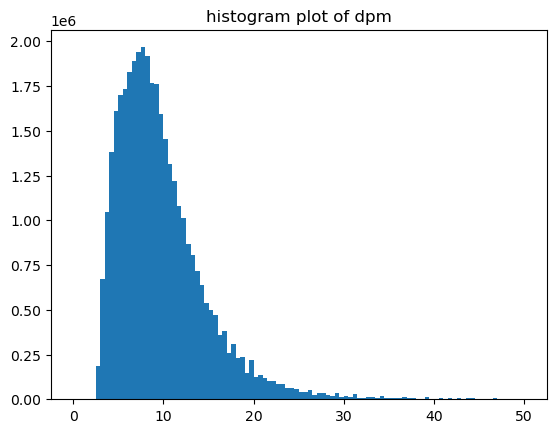

In [26]:
plt.hist(df['dpm'], bins=100, range=(0,50))
plt.title('histogram plot of dpm')
plt.savefig('../plots/dpm_hist.png')
plt.show()

C:\Users\amy_w\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


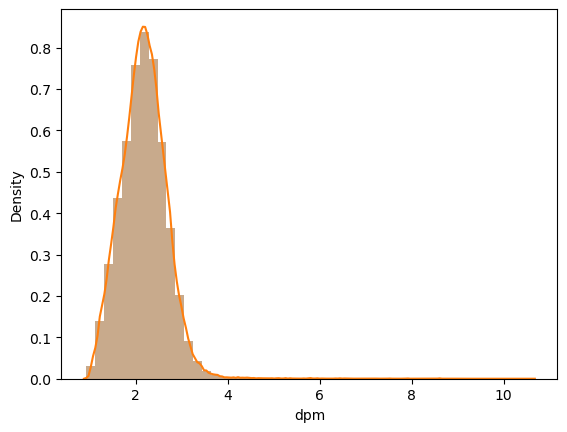

In [28]:
# dpm shows a skewness to the right, operate log transformation to normalise
import seaborn as sns
from numpy import log

sns.distplot(df['dpm'].apply(log), bins=50)
plt.savefig('../plots/log_dpm_hist.png')
plt.show()

most dpm values fall in (2.72, 20.09) which is (exp(1), exp(3))

In [30]:
df = df.loc[(df['dpm']>2.72) & (df['dpm']<20.09)]
df.to_csv('../preprocessed_data/df_processed.csv', index=False)
df.shape

(35741810, 9)